### About 

"""
#++++++++++++++++++++++++++++++++++++++++++++++

    Project: Part of final project for Georgia Tech Institute of Technology course DL, CS 7643. 

    Totality of this code is non-proprietary and may be used at will. 

#++++++++++++++++++++++++++++++++++++++++++++++


Description: 

@brief a notebook defining initial prototyping of model definition, dataset object instantiator, model trainer, and actual model training and evaluation.

@author: Greg Zdor (gzdor@icloud.com)

@date Date_Of_Creation: 3/25/2023 

@date Last_Modification 3/25/2023 

No Copyright - use at will

"""

In [2]:
# Imports 

# System level imports 
import os 
import sys
import time 
import yaml
from datetime import datetime

# ML and data science imports 
import torch
import torchinfo
import torchmetrics
import torch.nn as nn
import pytorch_lightning as pl
from torch.utils.data import Dataset, DataLoader

# Add local source files to namespace 
sys.path.append(f'..{os.sep}..{os.sep}')

# Local imports
from pkgs.utils.plotting_utils import * 
from pkgs.data_loaders.memory_mapper import load_parameters, SigMFDataMMapper
from pkgs.data_loaders.sigmf_dataset import SigMFDataset, IQDataAugmenter

now = datetime.now()
print(f'\n\nLast time this cell was run was \n\n  {now.strftime("%d/%m/%Y %H:%M:%S")}\n\n')




Last time this cell was run was 

  13/04/2023 21:17:05




User, update the following path according to your repo  location

In [3]:
start_dir = os.getcwd() 
os.chdir(f'..{os.sep}..{os.sep}..{os.sep}')
repo_root_path = os.getcwd() 
os.chdir(start_dir)

print(f'\n Repo location of:   {repo_root_path}')


 Repo location of:   /MLSR_Shared_Folder/gzdor/cs7643_pytorch/rf_fingerprinting_project/Radio_Frequency_Fingerprinting_802.11


#### Define dataset

In [4]:
# Set up dataset object
dataset_config_path = os.path.join(repo_root_path, "src", "pkgs", "data_loaders", "memory_mapper.yml")
with open(dataset_config_path, "rt") as h_file:
    parameters = yaml.safe_load(h_file)

    
memmapper = SigMFDataMMapper(parameters)
dataset = SigMFDataset("training", memmapper, transform = IQDataAugmenter())


memmap base path: self.mmap_dir:  /MLSR_Shared_Folder/gzdor/cs7643_pytorch/rf_fingerprinting_project/data/MemMapData


#### Visualize example model input tensor features from dataset

Single raw data sample is 2d tensor of shape:  torch.Size([2, 128])


Creating time domain plot.




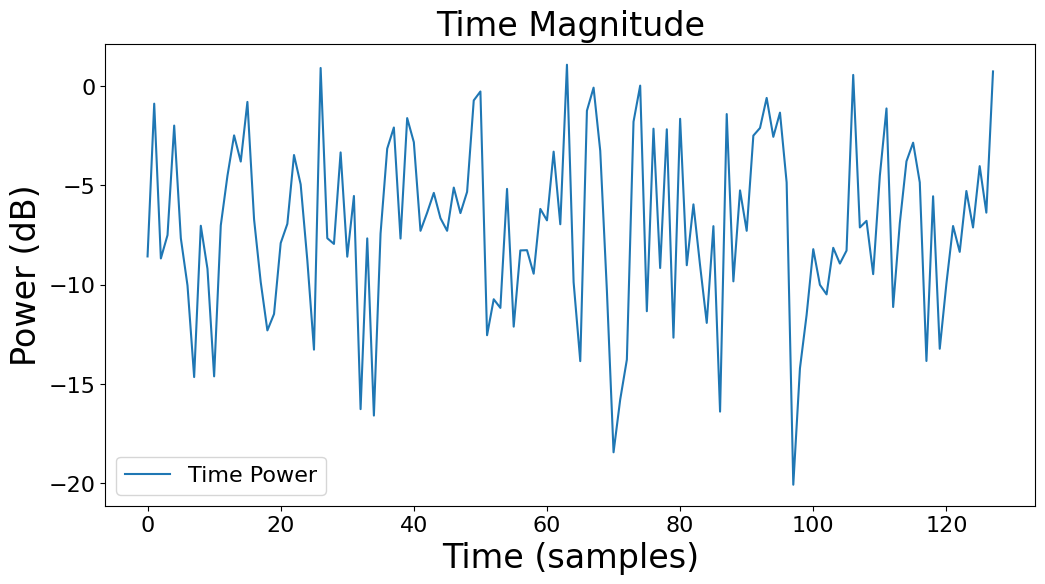



Creating frequency domain plot.




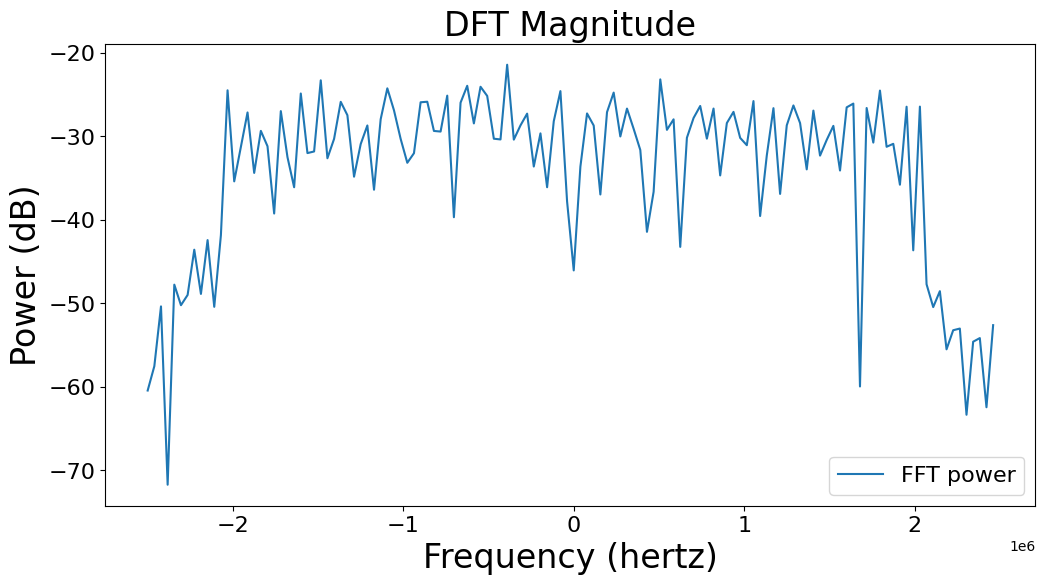

In [4]:
# Visualize samples from dataset 
real_samples  = dataset[0][0][0].numpy() 
imag_samples  = dataset[0][0][1].numpy()
iq = real_samples + imag_samples*1j

print(f'Single raw data sample is 2d tensor of shape:  {dataset[0][0].shape}')

create_time_domain_plot(iq)

create_dft(iq, 128, 5e6)

#### Create PyTorch Lightning data module 

In [5]:
# Create Pytorch Lightning module for dataset 

class LightningOracleDataset(pl.LightningDataModule): 

    def __init__(self): 
        """
        @brief constructor 

        @type parameters dict 
        @param parameters the input parameters from the mem mapper yaml config file.
        """

        super(LightningOracleDataset, self).__init__() 

        self.mmapper = SigMFDataMMapper(parameters)
        self.batch_size = parameters.get("batch_size", 1024)
        self.num_workers = parameters.get("num_workers", 2)


    def setup(self, stage: str):
        
        self.mmapper.map()

        self.sigmf_training =\
            SigMFDataset("training",
                         self.mmapper,
                         IQDataAugmenter())
        
        self.sigmf_validation =\
            SigMFDataset("validation", self.mmapper)
        
        self.sigmf_test = SigMFDataset("test", self.mmapper)


    def train_dataloader(self):
        return DataLoader(self.sigmf_training,
                          batch_size=self.batch_size,
                          num_workers=self.num_workers,
                          shuffle=True,
                          pin_memory=True)
    
    def val_dataloader(self):
        return DataLoader(self.sigmf_validation,
                          batch_size=self.batch_size,
                          num_workers=self.num_workers,
                          pin_memory=True)
    
    def test_dataloader(self):
        return DataLoader(self.sigmf_test,
                          batch_size=self.batch_size,
                          num_workers=self.num_workers,
                          pin_memory=True)


In [6]:
# Extract batch for data loader

dm = LightningOracleDataset()

dm.setup(stage="training")

dl = dm.train_dataloader()

batch = dl.__iter__().__next__()


memmap base path: self.mmap_dir:  /MLSR_Shared_Folder/gzdor/cs7643_pytorch/rf_fingerprinting_project/data/MemMapData


In [7]:
batch[1].shape

torch.Size([1024, 1])

In [8]:
batch[1].shape

torch.Size([1024, 1])

In [9]:
batch[1][1:25]

tensor([[ 4],
        [ 6],
        [14],
        [ 3],
        [ 5],
        [ 6],
        [12],
        [ 1],
        [11],
        [ 2],
        [ 5],
        [ 0],
        [ 4],
        [ 4],
        [ 2],
        [15],
        [ 8],
        [15],
        [11],
        [15],
        [ 7],
        [ 8],
        [ 1],
        [ 9]])

#### Define neural network

Put all model parameter value definitions in configuration to allow auto tuning in the future

In [6]:
cnn_classifier_cfg = {

    "num_classes"                 :        32, 
    "vector_len"                  :        128, # length in time of input signal sequence
    "n_features"                  :        2, # I and Q signal dimensions 
    "max_pool_kernel_size"        :        2, 
    "max_pool_stride"             :        1,
    "n_conv_layers"               :        2,
    "conv_layers"                 :  
        {
            "conv_1_n_filters"    :        128, 
            "conv_1_n_stride"     :        1, 
            "conv_1_kernal_size"  :        3,
            "conv_1_padding"      :        1, 
            "conv_2_n_filters"    :        16, 
            "conv_2_n_stride"     :        1, 
            "conv_2_kernal_size"  :        3,
            "conv_2_padding"      :        1, 
        }, 
    "conv_activations"            :        "Relu",
    "n_dense_layers"              :        2, 
    "dense_layers"                :
        {
            "dense_1_hidden_size" :        128, 
            "dense_2_hidden_size" :        128, 
            "dense_1_dropout"     :        0.2, 
            "dense_2_dropout"     :        0.2, 
        },
    "last_dense_layer_size"       :        64,
}

In [11]:
# Plain PyTorch model 

class CNNClassifier(nn.Module):
    
    def __init__(self, cfg):
        """
        @brief class constructor for convolution-based neural network 
        classifier. 

        @type cfg dict 
        @param cfg a dictionary of network configuration parameter values 
        """

        super(CNNClassifier, self).__init__()

        self.conv_1 = nn.Conv1d(
            cfg['n_features'],
            cfg['conv_layers']['conv_1_n_filters'],
            kernel_size = cfg['conv_layers']['conv_1_kernal_size'],
            stride = cfg['conv_layers']['conv_1_n_stride'], 
            padding = cfg['conv_layers']['conv_1_padding']
            )

        self.conv_2 = nn.Conv1d(
            cfg['conv_layers']['conv_1_n_filters'],
            cfg['conv_layers']['conv_2_n_filters'],
            kernel_size = cfg['conv_layers']['conv_2_kernal_size'],
            stride = cfg['conv_layers']['conv_2_n_stride'], 
            padding = cfg['conv_layers']['conv_2_padding']
            )

        self.conv_activation = nn.ReLU()

        self.maxpool = nn.MaxPool1d(cfg['max_pool_kernel_size'], cfg['max_pool_stride']) 

        dense_layer_input_size = 2016 #TODO parameterize this - remove hardcoded value

        self.dense_1 =  nn.Linear(dense_layer_input_size,
                                cfg['dense_layers']['dense_1_hidden_size'])

        self.dense_2 =  nn.Linear(cfg['dense_layers']['dense_2_hidden_size'],
                                cfg['last_dense_layer_size'])

        self.dense_drop_1 = nn.Dropout(cfg['dense_layers']['dense_1_dropout'])

        self.dense_drop_2 = nn.Dropout(cfg['dense_layers']['dense_2_dropout'])

        self.output_dense_layer = nn.Linear(cfg['last_dense_layer_size'], cfg['num_classes'])

        self.cfg = cfg

    def forward(self, x):
        """"
        @brief executes computation graph forward pass 

        @type x tensor 
        @param x neural network input tensor, of shape [batch_size, 2, 128]
        """

        # Convolution layers
        x = self.conv_1(x)
        x = self.conv_activation(x)
        x = self.maxpool(x)

        if self.cfg['n_conv_layers'] > 1: 
            x = self.conv_2(x)
            x = self.conv_activation(x)
            x = self.maxpool(x)

        x = torch.flatten(x, 1) 

        # Fully connected layers 
        x = self.dense_1(x)
        x = self.dense_drop_1(x)

        if self.cfg['n_dense_layers'] > 1: 
            x = self.dense_2(x)
            x = self.dense_drop_2(x)

        probabilities = self.output_dense_layer(x)

        return probabilities

In [12]:
view_model = False

if view_model:

    device = 'cuda' if torch.cuda.is_available() else 'cpu'

    # View model summary 
    batch_size = 16
    cnn_model = CNNClassifier(cnn_classifier_cfg).to(device)

    input_tensor_size = (batch_size, 2, 128)
    model_info = torchinfo.summary(cnn_model, input_size = input_tensor_size)
    print(f'\n\nModel summary\n\n{model_info}\n\n')

    # Pass in dummy data into model 
    x = torch.rand(1024, 2, 128).to(device)
    cnn_model.forward(x)

In [7]:
# Wrap model in Lightning module 

class LightningCNNClassifier(pl.LightningModule): 
    
    def __init__(self, cfg):
        """
        @brief class constructor for convolution-based neural network 
        classifier. 

        @type cfg dict 
        @param cfg a dictionary of network configuration parameter values 
        """

        super(LightningCNNClassifier, self).__init__()

        self.conv_1 = nn.Conv1d(
            cfg['n_features'],
            cfg['conv_layers']['conv_1_n_filters'],
            kernel_size = cfg['conv_layers']['conv_1_kernal_size'],
            stride = cfg['conv_layers']['conv_1_n_stride'], 
            padding = cfg['conv_layers']['conv_1_padding']
            )

        self.conv_2 = nn.Conv1d(
            cfg['conv_layers']['conv_1_n_filters'],
            cfg['conv_layers']['conv_2_n_filters'],
            kernel_size = cfg['conv_layers']['conv_2_kernal_size'],
            stride = cfg['conv_layers']['conv_2_n_stride'], 
            padding = cfg['conv_layers']['conv_2_padding']
            )

        self.conv_activation = nn.ReLU()

        self.maxpool = nn.MaxPool1d(cfg['max_pool_kernel_size'], cfg['max_pool_stride']) 

        dense_layer_input_size = 2016 #TODO parameterize this - remove hardcoded value

        self.dense_1 =  nn.Linear(dense_layer_input_size,
                                cfg['dense_layers']['dense_1_hidden_size'])

        self.dense_2 =  nn.Linear(cfg['dense_layers']['dense_2_hidden_size'],
                                cfg['last_dense_layer_size'])

        self.dense_drop_1 = nn.Dropout(cfg['dense_layers']['dense_1_dropout'])

        self.dense_drop_2 = nn.Dropout(cfg['dense_layers']['dense_2_dropout'])

        self.output_dense_layer = nn.Linear(cfg['last_dense_layer_size'], cfg['num_classes'])

        self.cfg = cfg
        
        self.get_softmax = nn.Softmax(dim = 1)
        
        self.loss = nn.CrossEntropyLoss()
        
        self.tr_batch_loss = [] 
        self.val_batch_loss = [] 
        self.test_batch_loss = [] 
        
        self.tr_batch_acc = [] 
        self.val_batch_acc = [] 
        self.test_batch_acc = []


    def forward(self, x):
        """"
        @brief executes computation graph forward pass 

        @type x tensor 
        @param x neural network input tensor, of shape [batch_size, 2, 128]
        """

        # Convolution layers
        x = self.conv_1(x)
        x = self.conv_activation(x)
        x = self.maxpool(x)

        if self.cfg['n_conv_layers'] > 1: 
            x = self.conv_2(x)
            x = self.conv_activation(x)
            x = self.maxpool(x)

        x = torch.flatten(x, 1) 

        # Fully connected layers 
        x = self.dense_1(x)
        x = self.dense_drop_1(x)

        if self.cfg['n_dense_layers'] > 1: 
            x = self.dense_2(x)
            x = self.dense_drop_2(x)

        probabilities = self.output_dense_layer(x)

        return probabilities


    def configure_optimizers(self): 
        optimizer = torch.optim.Adam(self.parameters(), lr  = 1e-3) #TODO 
        return optimizer 


    def training_step(self, train_batch, batch_idx):
        x, y = train_batch
        logits = self.forward(x)        
        loss = self.loss(logits, y.squeeze())
        acc = self._compute_accuracy(y, logits)
        
        self.log('train_loss', loss, prog_bar = True)
        self.log('train_accuracy', acc, prog_bar = True)
        
        self.tr_batch_loss.append(loss)
        self.tr_batch_acc.append(acc)
        
        return loss


    def validation_step(self, val_batch, batch_idx):
        x, y = val_batch
        logits = self.forward(x)
        loss = self.loss(logits, y.squeeze())
        acc = self._compute_accuracy(y, logits)
        
        self.log('validation_loss', loss, prog_bar = True)
        self.log('validation_accuracy', acc, prog_bar = True)
        
        self.val_batch_loss.append(loss)
        self.val_batch_acc.append(acc)
        
        return {"validation_loss" : loss, "validation_accuracy" : acc}
    
    
    def test_step(self, val_batch, batch_idx): 
        x, y = val_batch
        logits = self.forward(x)
        loss = self.loss(logits, y.squeeze())
        acc = self._compute_accuracy(y, logits)
        
        self.log('test_loss', loss, prog_bar = True)
        self.log('test_accuracy', acc, prog_bar = True)
        
        self.test_batch_loss.append(loss)
        self.test_batch_acc.append(acc)
        
        return {"test_loss" : loss, "test_accuracy" : acc}
    
    
    def predict_step(self, batch, batch_idx): 
        x, y = batch
        logits = self.forward(x)
        probabilties  = self.get_softmax(logits)
        
        return probabilties, y
    
        
    def on_train_epoch_end(self): 
        
        avg_tr_acc = torch.mean(torch.stack(self.tr_batch_acc))
        
        avg_tr_loss = torch.mean(torch.stack(self.tr_batch_loss))
        
        self.log("avg_tr_acc", avg_tr_acc)
        self.log("avg_tr_loss", avg_tr_loss)
        
        self.tr_batch_acc.clear()
        self.tr_batch_loss.clear()
    

    def on_validation_epoch_end(self): 
        
        avg_val_acc = torch.mean(torch.stack(self.val_batch_acc))
        
        avg_val_loss = torch.mean(torch.stack(self.val_batch_loss))
        
        self.log("avg_val_acc", avg_val_acc)
        self.log("avg_val_loss", avg_val_loss)
        
        self.val_batch_acc.clear()
        self.val_batch_loss.clear()
    
    
    def on_test_epoch_end(self): 
        
        avg_test_acc = torch.mean(torch.stack(self.test_batch_acc))
        
        avg_test_loss = torch.mean(torch.stack(self.test_batch_loss))
        
        self.log("avg_test_acc", avg_test_acc)
        self.log("avg_test_loss", avg_test_loss)
        
        self.test_batch_acc.clear()
        self.test_batch_loss.clear()

    
    def _compute_accuracy(self, labels, predictions): 
        
        acc = torchmetrics.functional.accuracy(
            torch.argmax(predictions, dim = 1), 
            labels.squeeze(), 
            task = "multiclass",
            num_classes = self.cfg['num_classes'],
        )
        
        return acc 

#### Execute training

Run example forward pass to make sure all tensor dimensionalites are aligned

In [14]:
view_pl_model = False

if view_pl_model:

    data_module = LightningOracleDataset()

    model = LightningCNNClassifier(cnn_classifier_cfg)

    x = batch

    print(type(x))

    print(x[0].shape)
    print(x[1].shape)

    print(x[0].dtype)
    print(x[1].dtype)

    loss = model.training_step(x, 0)

    loss

Run actual training

In [8]:
# Define training parameters 
n_epochs = 100

# Train model

data_module = LightningOracleDataset()

model = LightningCNNClassifier(cnn_classifier_cfg)

lightning_callbacks = [ 
    pl.callbacks.ModelCheckpoint(monitor = "validation_loss", mode = "min"), 
    pl.callbacks.EarlyStopping(monitor='validation_loss', patience=5),
]

# Configure trainer
t_start = time.time()
trainer = pl.Trainer(
    enable_progress_bar = True, 
    enable_checkpointing = True, 
    enable_model_summary = True,
    callbacks = lightning_callbacks, 
    max_epochs = n_epochs, 
    precision = 32, # options are 16 or 32 
) 

# multi gpu training via gpus=8, distributed_backend='dp' 


# Train
trainer.fit(model, data_module)

train_time_seconds = time.time() - t_start

print(f'\n\nTotal training time was {train_time_seconds} seconds, @ {str(train_time_seconds/n_epochs)} seconds per epoch.\n')


memmap base path: self.mmap_dir:  /MLSR_Shared_Folder/gzdor/cs7643_pytorch/rf_fingerprinting_project/data/MemMapData


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/MLSR_Shared_Folder/gzdor/Miniconda_Install/envs/rf-fingerprinting-proj-pytorch-cs7643/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/logger_connector/logger_connector.py:67: UserWarning: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
  warning_cache.warn(
Initializing distributed: GLOBAL_RANK: 0, MEMBER: 1/8
Initializing distributed: GLOBAL_RANK: 1, MEMBER: 2/8
Initializing distributed: GLOBAL_RANK: 2, MEMBER: 3/8
Initializing distributed: GLOBAL_RANK: 3, MEMBER: 4

Sanity Checking DataLoader 0: 100%|██████████| 2/2 [00:08<00:00,  4.10s/it]

/MLSR_Shared_Folder/gzdor/Miniconda_Install/envs/rf-fingerprinting-proj-pytorch-cs7643/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/logger_connector/result.py:432: PossibleUserWarning: It is recommended to use `self.log('validation_loss', ..., sync_dist=True)` when logging on epoch level in distributed setting to accumulate the metric across devices.
  warning_cache.warn(
/MLSR_Shared_Folder/gzdor/Miniconda_Install/envs/rf-fingerprinting-proj-pytorch-cs7643/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/logger_connector/result.py:432: PossibleUserWarning: It is recommended to use `self.log('validation_accuracy', ..., sync_dist=True)` when logging on epoch level in distributed setting to accumulate the metric across devices.
  warning_cache.warn(
/MLSR_Shared_Folder/gzdor/Miniconda_Install/envs/rf-fingerprinting-proj-pytorch-cs7643/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/logger_connector/result.py:432: PossibleUserWarning

Traceback (most recent call last):
  File "/MLSR_Shared_Folder/gzdor/Miniconda_Install/envs/rf-fingerprinting-proj-pytorch-cs7643/lib/python3.10/multiprocessing/util.py", line 300, in _run_finalizers
    finalizer()
  File "/MLSR_Shared_Folder/gzdor/Miniconda_Install/envs/rf-fingerprinting-proj-pytorch-cs7643/lib/python3.10/multiprocessing/util.py", line 224, in __call__
    res = self._callback(*self._args, **self._kwargs)
  File "/MLSR_Shared_Folder/gzdor/Miniconda_Install/envs/rf-fingerprinting-proj-pytorch-cs7643/lib/python3.10/multiprocessing/util.py", line 133, in _remove_temp_dir
    rmtree(tempdir)
  File "/MLSR_Shared_Folder/gzdor/Miniconda_Install/envs/rf-fingerprinting-proj-pytorch-cs7643/lib/python3.10/shutil.py", line 731, in rmtree
    onerror(os.rmdir, path, sys.exc_info())
  File "/MLSR_Shared_Folder/gzdor/Miniconda_Install/envs/rf-fingerprinting-proj-pytorch-cs7643/lib/python3.10/shutil.py", line 729, in rmtree
    os.rmdir(path)
OSError: [Errno 39] Directory not empty

Epoch 0: 100%|██████████| 489/489 [01:08<00:00,  7.13it/s, v_num=10, train_loss=2.450, train_accuracy=0.199, validation_loss=2.500, validation_accuracy=0.186]

/MLSR_Shared_Folder/gzdor/Miniconda_Install/envs/rf-fingerprinting-proj-pytorch-cs7643/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/logger_connector/result.py:432: PossibleUserWarning: It is recommended to use `self.log('avg_tr_acc', ..., sync_dist=True)` when logging on epoch level in distributed setting to accumulate the metric across devices.
  warning_cache.warn(
/MLSR_Shared_Folder/gzdor/Miniconda_Install/envs/rf-fingerprinting-proj-pytorch-cs7643/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/logger_connector/result.py:432: PossibleUserWarning: It is recommended to use `self.log('avg_tr_loss', ..., sync_dist=True)` when logging on epoch level in distributed setting to accumulate the metric across devices.
  warning_cache.warn(


Epoch 24:  37%|███▋      | 181/489 [00:29<00:50,  6.12it/s, v_num=10, train_loss=2.030, train_accuracy=0.313, validation_loss=1.960, validation_accuracy=0.333]

#### Evaluate model

In [ ]:
# Display train/validate accuracy and loss curves 

In [ ]:
# Calculate average accuracy

# Calculate per class accuracies 

# Create  confusion matrix

#### Next steps 

implement tuner wrapper - https://towardsdatascience.com/how-to-tune-pytorch-lightning-hyperparameters-80089a281646 